In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import os
from graphviz import Source
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/release/bin' #Esta línea es necesaria para que graphviz funcione en windows
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import imblearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


In [2]:
## Cargado del dataset original
data = pd.read_csv("C:/Users/pjlu_/Desktop/DataminingUPB.csv", sep=";")
data.rename(columns={'Humedad en aire':'hum_aire',
                          'Humedad en suelo 1':'hum_gnd_1',
                          'Humedad en suelo 2':'hum_gnd_2',
                          'Unnamed: 2':'unidad',
                    'Unnamed: 4':'unidad_3',
                    'Unnamed: 6':'unidad_5',
                    'Unnamed: 8':'unidad_7',
                    'Unnamed: 10':'unidad_9',
                    'Unnamed: 12':'unidad_11'},
                 inplace=True)

## Borrado de columna de unidades
data = data.drop(["unidad","unidad_3","unidad_5","unidad_7","unidad_9","unidad_11"],axis =1)

##Separado de los datos correspondientes al sujeto 1
data2 = data.drop(["EstadosPlanta_2","N_hojas_2","hum_gnd_2",],axis =1)

##Separado de los datos correspondientes al sujeto 2
data3 = data.drop(["EstadosPlanta_1","N_hojas_1","hum_gnd_1"],axis =1)

## Homogeneizado en encabezados de la tabla de datos de sujeto 1 y agregado de columna para la identificaciòn de estos
data2.rename(columns={'hum_gnd_1':'hum_gnd','EstadosPlanta_1':'EstadosPlanta','N_hojas_1':'N_hojas'},inplace=True)
data2['sujeto']= "1"

## Homogeneizado en encabezados de la tabla de datos de sujeto 2 y agregado de columna para la identificaciòn de estos
data3.rename(columns = {'hum_gnd_2':'hum_gnd','EstadosPlanta_2':'EstadosPlanta','N_hojas_2':'N_hojas'},inplace=True)
data3['sujeto'] = "2"

##Unión de los datos de sujetos 1 y 2 en un nuevo dataset
data4 = pd.concat([data2,data3])

## Eliminado de filas donde falte al menos un dato
data4 = data4.dropna(axis=0, how="any")

## Eliminado de las columnas fecha y N_hojas
data_nfecha = data4.drop(["Time","N_hojas"],axis = 1)


In [3]:
## Divisiòn de dataset en predictores y target
colnames = data_nfecha.columns.values.tolist()
predictores = colnames
target = colnames[5]
predictores.remove('EstadosPlanta')

In [4]:
## Divisiòn de la data en datos de entrenamiento y test

#Creaciòn de columna Training, donde el 75% seràn True y el 25% False (75 % pertenecen a los datos de entrenamiento y 25% a test) 
data_nfecha["Training"] = np.random.uniform(0,1, len(data_nfecha))<=0.75 

##Convirtiendo el dataset en dataset binario
data_nfecha['EstadosPlanta']= np.where(data_nfecha['EstadosPlanta']==3,2,data_nfecha['EstadosPlanta'])

## Separaciòn de los datos de entrenamiento y test
train, test = data_nfecha[data_nfecha["Training"]==True], data_nfecha[data_nfecha["Training"]==False]

In [5]:
## Creaciòn del árbol de decisiòn

X_train = train[predictores]
Y_train = train[target]

X_test = test[predictores]
Y_test = test[target]

## Árbol de decisión

In [6]:
arbol = DecisionTreeClassifier(criterion="entropy", max_depth=4, min_samples_split=20, random_state=99)


In [7]:
## Implementaciòn de Crossvalidaton
cv = KFold(n_splits= X_train.shape[0], shuffle=True, random_state=1)
scores=cross_val_score(arbol, X_train, Y_train, scoring="f1_macro", cv = 10, n_jobs=-1)
preds=cross_val_predict(arbol, X_train, Y_train, cv = 10, n_jobs=-1)

In [8]:
print(scores)

[1.         0.99845439 0.939538   0.84766117 0.63627813 0.45396825
 0.46531953 0.45866856 0.33872059 0.53316319]


(array([10534.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1508.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

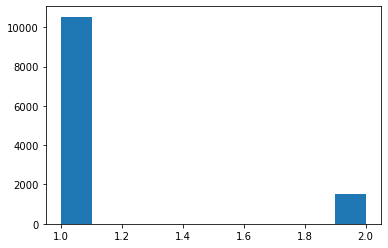

In [9]:
plt.hist(preds)

## Matriz de confusión

In [10]:
pd.crosstab(Y_train,preds, rownames=["Real"],colnames=["Predicciones"])

Predicciones,1.0,2.0
Real,,
1.0,9395,733
2.0,1139,775


In [11]:
target_names = ['1', '2']
print(classification_report(Y_train, preds, target_names=target_names))

              precision    recall  f1-score   support

           1       0.89      0.93      0.91     10128
           2       0.51      0.40      0.45      1914

    accuracy                           0.84     12042
   macro avg       0.70      0.67      0.68     12042
weighted avg       0.83      0.84      0.84     12042



<AxesSubplot:>

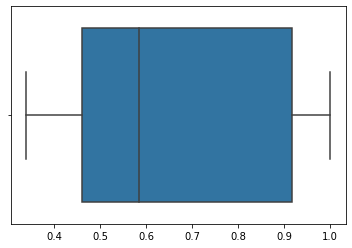

In [12]:
sns.boxplot(scores)

## Random forest

In [13]:
forest = RandomForestClassifier(n_jobs=-1, oob_score=True,n_estimators=500,criterion="entropy", max_depth=4, min_samples_split=20, random_state=99)


In [14]:
## Implementaciòn de Crossvalidaton
cv = KFold(n_splits= X_train.shape[0], shuffle=True, random_state=1)
scores_forest=cross_val_score(forest, X_train, Y_train, scoring="f1_macro", cv = 10, n_jobs=-1)
preds_forest=cross_val_predict(forest, X_train, Y_train, cv = 10, n_jobs=-1)

In [15]:
print(scores_forest)

[0.72028784 0.75067683 0.80954766 0.62632166 0.53924515 0.45545002
 0.57251952 0.45903957 0.31827356 0.46544324]


(array([10989.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1053.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

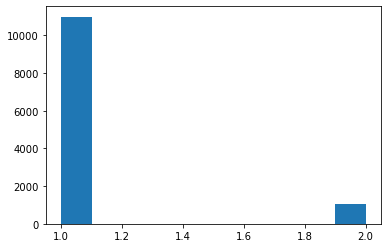

In [16]:
plt.hist(preds_forest)

In [17]:
pd.crosstab(Y_train,preds_forest, rownames=["Real"],colnames=["Predicciones"])

Predicciones,1.0,2.0
Real,,
1.0,9418,710
2.0,1571,343


In [18]:
target_names = ['1', '2']
print(classification_report(Y_train, preds_forest, target_names=target_names))

              precision    recall  f1-score   support

           1       0.86      0.93      0.89     10128
           2       0.33      0.18      0.23      1914

    accuracy                           0.81     12042
   macro avg       0.59      0.55      0.56     12042
weighted avg       0.77      0.81      0.79     12042



<AxesSubplot:>

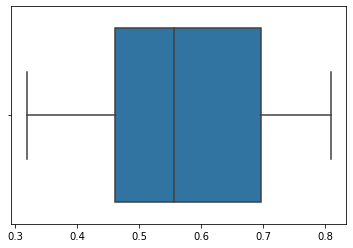

In [19]:
sns.boxplot(scores_forest)

## Random Forest con opción de data balanceada

In [20]:
forest2 = RandomForestClassifier(n_jobs=-1, oob_score=True,n_estimators=500,criterion="entropy",class_weight='balanced', max_depth=4, min_samples_split=20, random_state=99)


In [21]:
## Implementaciòn de Crossvalidaton
cv = KFold(n_splits= X_train.shape[0], shuffle=True, random_state=1)
scores_forest2=cross_val_score(forest2, X_train, Y_train, scoring="f1_macro", cv = 10, n_jobs=-1)
preds_forest2=cross_val_predict(forest2, X_train, Y_train, cv = 10, n_jobs=-1)

In [22]:
print(scores_forest2)

[1.         0.99845439 1.         0.95022083 0.92999792 0.98179243
 0.54115279 0.13800198 0.40573921 0.71985335]


(array([7718.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4324.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

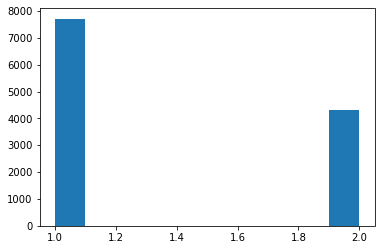

In [23]:
plt.hist(preds_forest2)

In [24]:
pd.crosstab(Y_train,preds_forest2, rownames=["Real"],colnames=["Predicciones"])

Predicciones,1.0,2.0
Real,,
1.0,7641,2487
2.0,77,1837


In [25]:
target_names = ['1', '2']
print(classification_report(Y_train, preds_forest2, target_names=target_names))

              precision    recall  f1-score   support

           1       0.99      0.75      0.86     10128
           2       0.42      0.96      0.59      1914

    accuracy                           0.79     12042
   macro avg       0.71      0.86      0.72     12042
weighted avg       0.90      0.79      0.81     12042



<AxesSubplot:>

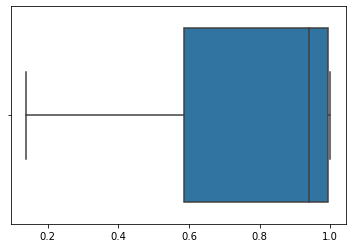

In [26]:
sns.boxplot(scores_forest2)

## Datos Normalizados

In [27]:
X_norm_train = StandardScaler().fit_transform(X_train)
X_norm_test = StandardScaler().fit_transform(X_test)

X_norm_train

array([[-0.34124558, -1.06699582, -0.33426404, -1.16645862, -0.66715185,
        -0.8473941 ],
       [-0.34970829, -0.18721509, -0.36765973, -1.16645862, -0.66631808,
        -0.8473941 ],
       [-0.34970829,  1.36746592, -0.38435758, -0.9236749 , -0.66631808,
        -0.8473941 ],
       ...,
       [-0.59512682, -1.58522282, -0.34261296,  1.74694598, -0.67715713,
         1.18008846],
       [-0.53588786,  1.03001578, -0.40105542,  1.74694598, -0.66965317,
         1.18008846],
       [-0.73053014, -1.44060133, -0.3927065 ,  1.26137855, -0.66548431,
         1.18008846]])

## Arbol de decisión normalizado

In [28]:
arbol_norm = DecisionTreeClassifier(criterion="entropy", max_depth=4, min_samples_split=20, random_state=99)

## Implementaciòn de Crossvalidaton
cv = KFold(n_splits= X_norm_train.shape[0], shuffle=True, random_state=1)
scores_norm=cross_val_score(arbol_norm, X_norm_train, Y_train, scoring="f1_macro", cv = 10, n_jobs=-1)
preds_norm=cross_val_predict(arbol_norm, X_norm_train, Y_train, cv = 10, n_jobs=-1)

(array([10534.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1508.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

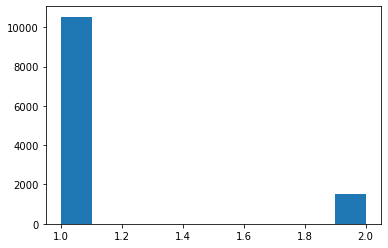

In [29]:
plt.hist(preds_norm)

## Matriz de confusiòn para datos normalizados - Arbol de decisión

In [30]:
pd.crosstab(Y_train,preds_norm, rownames=["Real"],colnames=["Predicciones"])

Predicciones,1.0,2.0
Real,,
1.0,9395,733
2.0,1139,775


In [31]:
target_names = ['1', '2']
print(classification_report(Y_train, preds_norm, target_names=target_names))

              precision    recall  f1-score   support

           1       0.89      0.93      0.91     10128
           2       0.51      0.40      0.45      1914

    accuracy                           0.84     12042
   macro avg       0.70      0.67      0.68     12042
weighted avg       0.83      0.84      0.84     12042



<AxesSubplot:>

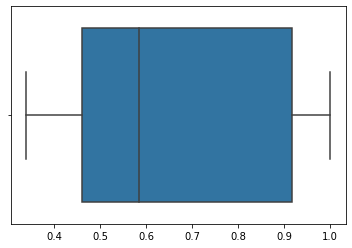

In [32]:
sns.boxplot(scores_norm)

## Random Forest normalizado

In [33]:
forest_norm = RandomForestClassifier(n_jobs=-1, oob_score=True,n_estimators=500,criterion="entropy",class_weight='balanced', max_depth=4, min_samples_split=20, random_state=99)

## Implementaciòn de Crossvalidaton
cv = KFold(n_splits= X_norm_train.shape[0], shuffle=True, random_state=1)
scores_forest_norm=cross_val_score(forest_norm, X_norm_train, Y_train, scoring="f1_macro", cv = 10, n_jobs=-1)
preds_forest_norm=cross_val_predict(forest_norm, X_norm_train, Y_train, cv = 10, n_jobs=-1)

(array([7718.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4324.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

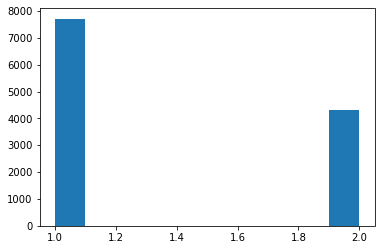

In [34]:
plt.hist(preds_forest_norm)

## Matriz de confusiòn para datos normalizados - Random Forest

In [35]:
pd.crosstab(Y_train,preds_forest_norm, rownames=["Real"],colnames=["Predicciones"])

Predicciones,1.0,2.0
Real,,
1.0,7641,2487
2.0,77,1837


In [36]:
target_names = ['1', '2']
print(classification_report(Y_train, preds_forest_norm, target_names=target_names))

              precision    recall  f1-score   support

           1       0.99      0.75      0.86     10128
           2       0.42      0.96      0.59      1914

    accuracy                           0.79     12042
   macro avg       0.71      0.86      0.72     12042
weighted avg       0.90      0.79      0.81     12042



<AxesSubplot:>

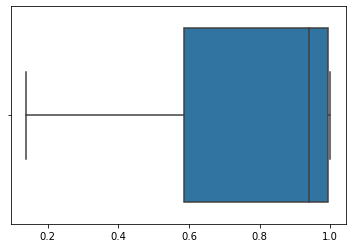

In [37]:
sns.boxplot(scores_forest_norm)

## Analisis de componentes principales

In [38]:
pca = PCA()
pca.fit(X_norm_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) +1

In [39]:
pca.explained_variance_ratio_

array([0.32773162, 0.1987462 , 0.16662452, 0.15444622, 0.13108841,
       0.02136303])

## Entrenamiento modelo

In [40]:
forest_norm.fit(X_norm_train,Y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, min_samples_split=20, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=99)

In [41]:
Preds_Mod_Trained = forest_norm.predict(X_norm_test)

In [42]:
##X_norm_train.

In [43]:
puntajes_p = cross_val_score(forest_norm, X_norm_test, Y_test, cv=10, scoring="accuracy")
print("Metricas cross_validation prueba", puntajes_p)

print("Media de cross_validation prueba", puntajes_p.mean())

y_pred = forest_norm.predict(X_norm_test)
print('matriz de confusion prueba',cm(Y_test,Preds_Mod_Trained))
tp, fn, fp, tn = cm(Y_test, Preds_Mod_Trained).ravel()
print('tn=',tn)
print('fp=',fp)
print('fn=',fn)
print('tp=',tp)
print('sensibilidad=',tp/(tp+fn))
print('exactitud=',(tn+tp)/(tn+fp+fn+tp))
print('precision=',tp/(tp+fp))
print('especificidad',tn/(tn+fp))

Metricas cross_validation prueba [0.9902439  1.         1.         0.99022005 0.92420538 0.96821516
 0.59657702 0.17359413 0.39364303 0.78484108]
Media de cross_validation prueba 0.7821539745959807
matriz de confusion prueba [[2514  876]
 [   5  696]]
tn= 696
fp= 5
fn= 876
tp= 2514
sensibilidad= 0.7415929203539823
exactitud= 0.7846492300171107
precision= 0.9980150853513299
especificidad 0.992867332382311


In [44]:
cm(Y_test,Preds_Mod_Trained)

array([[2514,  876],
       [   5,  696]], dtype=int64)

In [45]:
target_names = ['1', '2']
print(classification_report(Y_test, Preds_Mod_Trained, target_names=target_names))

              precision    recall  f1-score   support

           1       1.00      0.74      0.85      3390
           2       0.44      0.99      0.61       701

    accuracy                           0.78      4091
   macro avg       0.72      0.87      0.73      4091
weighted avg       0.90      0.78      0.81      4091



### Persistencia del modelo

In [46]:
#Exportar el modelo entrenado
from joblib import dump
dump(forest_norm, 'Random_Forest_Binario_Tesis.joblib')

['Random_Forest_Binario_Tesis.joblib']

In [47]:
import pickle

pkl_filename = "C:/Users/pjlu_/My Documents/EjerciciosMachineLearning/Random_Forest_Binario_Tesis.pkl"

with open(pkl_filename, 'wb') as file:
    pickle.dump(forest_norm, file)